# Checking the 1 month long nudged runs against previous runs
I want to validate their function before submitting something longer.

In [58]:
import sys

# Add last directory to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis")
# Add common resources
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

Set up directories based on where the program is being run from

In [59]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'nudging_dev/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


Get unnudged output from the normal compset/resolution as a control:

In [60]:
val_dir = 'NorESM_validation/'
basecase = '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01.nc'

os.path.exists('%s%s' % (val_dir, basecase))

bc = xr.open_dataset('%s%s' % (val_dir, basecase))

nudging_cases = os.listdir(case_dir)

In [61]:
arc_slf = 100*(bc['CT_SLFXCLD_ISOTM']/bc['CT_CLD_ISOTM']).sel(lat=slice(66.667,90)).mean(dim=['lat','lon','time'])
caselist = [arc_slf]
namelist = ['Unnudged']

_rng = [66.667, 90]

for i in nudging_cases:
#    print(os.path.exists('%s%s/atm/hist/%s.cam.h0.2000-01.nc' % (case_dir, i,i)))
    da = xr.open_dataset('%s%s/atm/hist/%s.cam.h0.2000-01.nc' % (case_dir, i,i))
    da = add_weights(da)

    mask = np.bitwise_or(da['lat']<_rng[0], da['lat']>_rng[1])
    weight = da['cell_weight']
    arc_slf = 100*masked_average(da['CT_SLFXCLD_ISOTM']/da['CT_CLD_ISOTM'], dim=['lat','lon','time'],weights=weight, mask=mask)
    
#    arc_slf = 100*(da['CT_SLFXCLD_ISOTM']/da['CT_CLD_ISOTM']).sel(lat=slice(66.667,90)).mean(dim=['lat','lon','time'])
    caselist.append(arc_slf)
    namelist.append(i)

In [70]:
namelist

['Unnudged',
 '20200109_drydepmanual',
 '20200110_144808_singleparam_nudgetest_wbf_1_inp_1000',
 '20200109_nfclimo_f19tn14',
 '20200108_newfilelist',
 '20200110_140715_singleparam_nudgetest_1_1']

In [73]:
selected = ['Unnudged','20200108_newfilelist', '20200110_144808_singleparam_nudgetest_wbf_1_inp_1000','20200109_nfclimo_f19tn14']

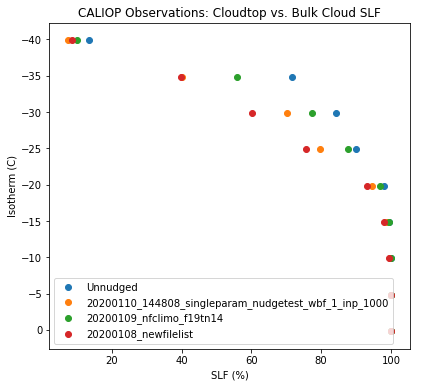

In [74]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig1)#, hspace=0.4)
f1_ax1 = fig1.add_subplot(spec1[0, :-1])
#f1_ax2 = fig1.add_subplot(spec1[0, -1], sharey=f1_ax1)
#axes = [f1_ax1, f1_ax2]
#plt.setp(f1_ax2.get_yticklabels(), visible=False)

fig1.gca().invert_yaxis()
f1_ax1.set_title('CALIOP Observations: Cloudtop vs. Bulk Cloud SLF'); f1_ax1.set_ylabel('Isotherm (C)'); f1_ax1.set_xlabel('SLF (%)')
#f1_ax2.set_title('NorESM error'); f1_ax2.set_xlabel('SLF Error (%)')
for da,name in zip(caselist, namelist):
    if name in selected:
        f1_ax1.scatter(da, da['isotherms_mpc']-273, label=name)#, color = 'r', marker='D')

f1_ax1.legend(loc='lower left')

In [52]:
filename = 'nudging_comparison.png'

if not os.path.exists(filename):
    fig1.savefig(output_dir + filename,format = 'png', dpi = 200)
    fig.clf()

This is pretty surprising to me. The two different compsets that I am using have noticeably different SLF trends, which the nudged compset producing significantly less SLF at the colder isotherms, which may be better in line with our observations. The least difference is between the nudged runs that only have a different resolution (orange and green). I should look at the difference between the two compsets.

Nudging compset:
2000_CAM60%NUDGEPTAERO_CLM50%SP_CICE%PRES_DOCN%DOM_RTM_SGLC_SWAV
Normal compset:
2000_CAM60_CLM50%SP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV